In [87]:
import time
import requests
import urllib
import pandas as pd
import numpy as np
from random import choice,uniform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import LogFormatter , LogFormatterExponent
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



In [111]:
def plot_lat_lon_prep(title=None):

    osm_img = cimgt.Stamen('terrain-background')

    fig = plt.figure(figsize=(18,10)) # open matplotlib figure
    ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
    if title is not None:
        ax1.set_title(title,fontsize=16)
    extent = [-124.7844079,-66.9513812, 24.7433195, 49.3457868] #
    ax1.set_extent(extent) # set extents
    ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
    ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
    lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
    lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
    ax1.xaxis.set_major_formatter(lon_formatter) # set lons
    ax1.yaxis.set_major_formatter(lat_formatter) # set lats
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax1.add_image(osm_img, int(scale))

    return ax1

bounds = [0, 100, 1000, 2000, 4000, 6000, 8000, 10000, 15000]
#bounds = [0, 1000, 2000, 8000, 10000, 15000]
stretched_bounds = np.interp(np.linspace(0, 1, 257), np.linspace(0, 1, len(bounds)), bounds)
norm = colors.BoundaryNorm(stretched_bounds, ncolors=256)
smap = plt.cm.ScalarMappable(norm=norm, cmap='jet')

In [4]:
def call_elevation(lat, lon, neg=False):

    if neg == False:
        multi = 1
    if neg == True:
        multi = -1

    params = {
        'output': 'json',
        'x': lon,
        'y': lat,
        'units': 'Feet'
    }

    time.sleep(.5)

    url = r'https://nationalmap.gov/epqs/pqs.php?'

    result = requests.get((url + urllib.parse.urlencode(params)))
    
    if result.ok:
        return float(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])*multi

    else:
        pass

In [125]:
lats = np.arange(27.5,50,2.5)
lons = np.arange(-125,-67,2.5)

In [123]:
lats

array([27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5])

In [126]:
lons

array([-125. , -122.5, -120. , -117.5, -115. , -112.5, -110. , -107.5,
       -105. , -102.5, -100. ,  -97.5,  -95. ,  -92.5,  -90. ,  -87.5,
        -85. ,  -82.5,  -80. ,  -77.5,  -75. ,  -72.5,  -70. ,  -67.5])

In [127]:
print(len(lats)*len(lons))

216


In [120]:
def grid_search_evel(lats,lons,loops):
    df = pd.DataFrame()
    for i in range(loops):
        coor = choice([[x,y] for x in lats for y in lons])
        lat = coor[0]
        lon = coor[1]
        elev = call_elevation(lat,lon)
        data = {'lat':[lat],'lon':[lon],'evel':[elev]}
        df = pd.concat([df, pd.DataFrame(data,index=[i])])
    return df

In [128]:
grid_df = grid_search_evel(lats,lons,100)
grid_df

,lat,lon,evel
0,30.0,-110.0,-1000000.00
1,35.0,-97.5,1098.69
2,45.0,-87.5,579.91
3,35.0,-70.0,-1000000.00
4,37.5,-90.0,615.55
...,...,...,...
95,27.5,-112.5,-1000000.00
96,45.0,-107.5,4501.47
97,32.5,-105.0,5901.32
98,42.5,-100.0,2631.94


In [136]:
print("Number of Evelations Returned: {}".format(len(grid_df[(grid_df['evel']>-1000000)])))
print("Maximum Evelation Returned: {}".format(grid_df.evel.max()))

Number of Evelations Returned: 72
Maximum Evelation Returned: 7415.37


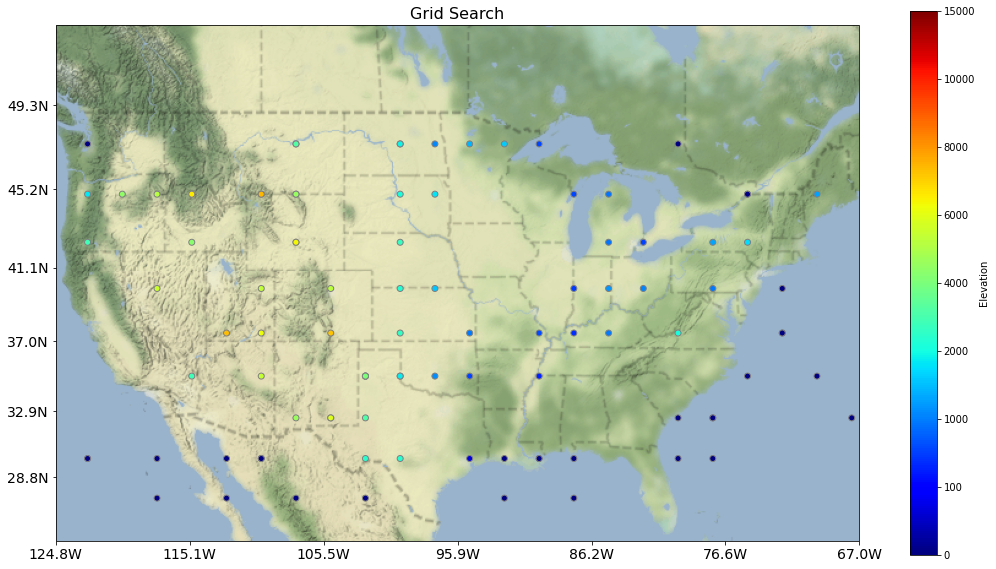

In [129]:
ax = plot_lat_lon_prep("Grid Search")
im = ax.scatter(grid_df['lon'], grid_df['lat'], edgecolors='grey', facecolor = smap.to_rgba(grid_df['evel']), transform=ccrs.PlateCarree())
cbar = plt.colorbar(smap, ticks=bounds)
cbar.set_label('Elevation')
plt.show()

In [130]:
def rand_search_evel(loops):
    df = pd.DataFrame()
    for i in range(loops):
        lat=uniform(24.7433195, 49.3457868)
        lon=uniform(-124.7844079,-66.9513812)
        elev = call_elevation(lat,lon)
        data = {'lat':[lat],'lon':[lon],'evel':[elev]}
        df = pd.concat([df, pd.DataFrame(data,index=[i])])
    return df

In [140]:
rand_df = rand_search_evel(100)
rand_df

,lat,lon,evel
0,45.505918,-76.786195,-1000000.00
1,46.639308,-114.430203,5882.83
2,29.125848,-96.114787,69.00
3,30.610533,-121.239291,-1000000.00
4,47.713565,-108.050647,2630.78
...,...,...,...
95,36.823677,-87.918503,444.32
96,26.147743,-121.487291,-1000000.00
97,33.885474,-90.497968,138.34
98,37.404357,-113.374501,8074.38


In [141]:
print("Number of Evelations Returned: {}".format(len(rand_df[(rand_df['evel']>-1000000)])))
print("Maximum Evelation Returned: {}".format(rand_df.evel.max()))

Number of Evelations Returned: 68
Maximum Evelation Returned: 8199.64


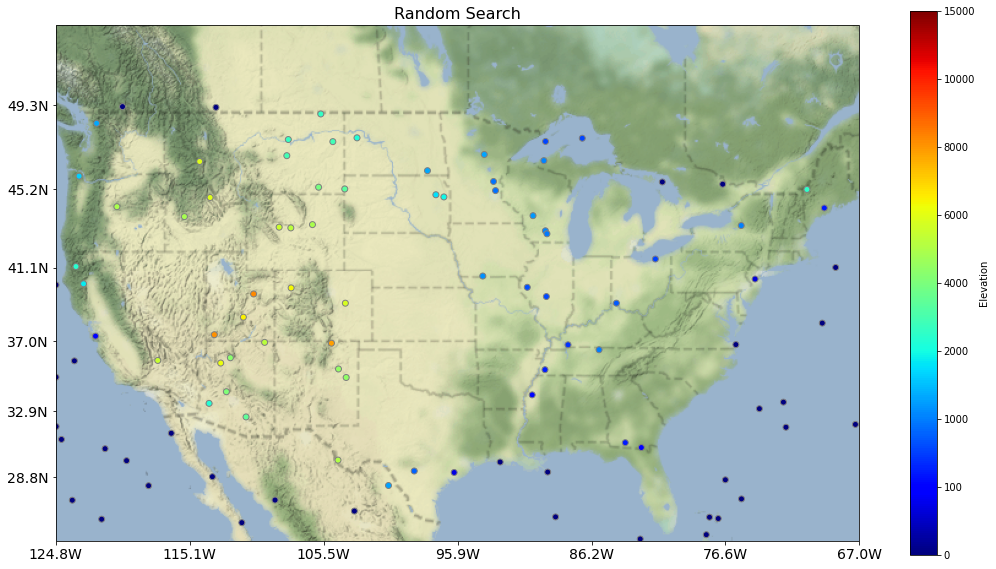

In [142]:
ax = plot_lat_lon_prep("Random Search")
im = ax.scatter(rand_df['lon'], rand_df['lat'], edgecolors='grey', facecolor = smap.to_rgba(rand_df['evel']), transform=ccrs.PlateCarree())
cbar = plt.colorbar(smap, ticks=bounds)
cbar.set_label('Elevation')
plt.show()

In [184]:
def call_elevation_tf(lat, lon):

    multi = -1

    params = {
        'output': 'json',
        'x': lon,
        'y': lat,
        'units': 'Feet'
    }

    time.sleep(.5)

    url = r'https://nationalmap.gov/epqs/pqs.php?'

    result = requests.get((url + urllib.parse.urlencode(params)))
    
    if result.ok:
        return float(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])*multi

    else:
        pass

In [192]:
float(requests.get((url + urllib.parse.urlencode({'output': 'json','x': -80,'y': 40,'units': 'Feet'}))).json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])*-1

-904.45

In [193]:
import tensorflow as tf
import tensorflow_probability as tfp

lat = tf.Variable(40,dtype=tf.float16,constraint=lambda t: tf.clip_by_value(t, 24.7433195, 49.3457868))
lon = tf.Variable(-80,dtype=tf.float16,constraint=lambda t: tf.clip_by_value(t, -124.7844079,-66.9513812))

url = r'https://nationalmap.gov/epqs/pqs.php?'

#loss = lambda: 3 * lon * lat + 2 * lon * lon
loss = lambda: float(requests.get((url + urllib.parse.urlencode({'output': 'json','x': lon,'y': lat,'units': 'Feet'}))).json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])*-1
trace_fn = lambda traceable_quantities: {'loss': traceable_quantities.loss, 'lat': lat, 'lon':lon}
trace = tfp.math.minimize(loss,
                           num_steps=5,
                           trainable_variables = [lat, lon],
                           trace_fn=trace_fn,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1))



JSONDecodeError: [Errno Expecting value]  <div style="border: 3px solid #4991C5; font:1.5em; font-family:tahoma,calibri,arial; font-weight:bold; color:#1A4369; padding:5px; margin:10px; text-align:center">  The specified URL cannot be found. </div><!--0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234-->
: 1

In [194]:
trace

{'loss': <tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([3200.      , 3156.0508  , 3112.204   , 3068.461   , 3024.8242  ,
        2981.296   , 2937.877   , 2894.5664  , 2851.371   , 2808.288   ,
        2765.3223  , 2722.4727  , 2679.7412  , 2637.13    , 2594.6396  ,
        2552.2734  , 2510.0283  , 2467.9102  , 2425.917   , 2384.0508  ,
        2342.3115  , 2300.7012  , 2259.2217  , 2217.872   , 2176.6523  ,
        2135.5654  , 2094.6113  , 2053.788   , 2013.1006  , 1972.5459  ,
        1932.125   , 1891.8398  , 1851.6895  , 1811.6748  , 1771.7949  ,
        1732.0518  , 1692.4443  , 1652.9727  , 1613.6396  , 1574.4404  ,
        1535.3789  , 1496.4531  , 1457.6641  , 1419.0107  , 1380.4951  ,
        1342.1143  , 1303.8701  , 1265.7607  , 1227.7891  , 1189.9521  ,
        1152.251   , 1114.6855  , 1077.2549  , 1039.959   , 1002.7959  ,
         965.76953 ,  928.875   ,  892.11426 ,  855.48926 ,  818.9971  ,
         782.63574 ,  746.4072  ,  710.3125  ,  674.34766 ,  638.51

In [190]:
print("optimized value is {:.4f} {:.4f} with loss {:.4f}".format(trace['lat'][-1],trace['lon'][-1], trace['loss'][-1]))

optimized value is 49.3458 -70.6696 with loss -462.0557
